In [23]:
import pandas as pd
import numpy as np
import anndata as ann
import scanpy as sc
import os, sys
from scipy.stats import pearsonr as pr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1
from sklearn.metrics import precision_recall_curve as prc
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, average_precision_score


In [24]:
sc.set_figure_params(dpi=400)

# Load Anndata

In [25]:
# load data
adata = sc.read('METMAP500.h5ad')
adata

/home/wang3712/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 259 × 1512
    obs: 'Tissue', 'prim_or_metas', 'metas_site'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [26]:
# reformat the tissue as just the name
from collections import Counter
all_tissues = adata.obs['Tissue'].unique()
new_tissues = []
for tissue in adata.obs['Tissue']:
    if tissue.startswith('CNS/BRAIN'):
        new_tissues.append('BRAIN')
    else:
        new_tissues.append(tissue.split('/')[0].split('_')[0])
adata.obs['new_tissue'] = new_tissues
adata.obs['new_tissue'].unique()

array(['BOWEL', 'SKIN', 'LUNG', 'BLADDER', 'BRAIN', 'PANCREAS', 'OVARY',
       'KIDNEY', 'HEAD AND NECK', 'UTERUS', 'LIVER', 'BREAST',
       'ESOPHAGUS'], dtype=object)

# One hot encoding

In [27]:
# one hot encoding the labels
def one_hot_encode(labels, num_classes):
    unique_labels = list(set(labels))
    
    one_hot_encoded = np.zeros(shape=(len(labels), num_classes))

    # Encode labels by setting the corresponding index to 1 in each row
    for i, label in enumerate(labels):
        index = unique_labels.index(label)
        one_hot_encoded[i, index] = 1

    return one_hot_encoded, unique_labels

In [28]:
one_hot_labels_tissue,_ = one_hot_encode(adata.obs['new_tissue'], len(adata.obs['new_tissue'].unique()))

In [29]:
one_hot_labels_site, uniqe_labels_site = one_hot_encode(adata.obs['metas_site'], len(adata.obs['metas_site'].unique()))

## One vs. All

In [30]:
one_hot_labels_site_one_vs_all = dict()
all_sites = adata.obs.metas_site.value_counts().index
for tissue in all_sites:
    print(tissue)
    tissues_to_learn = tissue
    one_vs_all_labels = []
    for i in adata.obs.metas_site:
        if  i == tissues_to_learn:
            one_vs_all_labels.append(1)
        else:
            one_vs_all_labels.append(0)
    adata.obs[tissue+'.1va'] = one_vs_all_labels
    one_hot_labels_site_one_vs_all[tissue], _ = one_hot_encode(adata.obs[tissue+'.1va'], len(adata.obs[tissue+'.1va'].unique()))

Neg
kidney
liver
bone
lung
brain


In [31]:
adata.obs

,Tissue,prim_or_metas,metas_site,new_tissue,Neg.1va,kidney.1va,liver.1va,bone.1va,lung.1va,brain.1va
ACH-000007,BOWEL,Primary,Neg,BOWEL,1,0,0,0,0,0
ACH-000008,SKIN,Primary,liver,SKIN,0,0,1,0,0,0
ACH-000012,LUNG,Primary,bone,LUNG,0,0,0,1,0,0
ACH-000015,LUNG,Primary,liver,LUNG,0,0,1,0,0,0
ACH-000018,BLADDER/URINARY TRACT,Primary,brain,BLADDER,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
ACH-000996,UTERUS,Primary,bone,UTERUS,0,0,0,1,0,0
ACH-000997,BOWEL,Primary,lung,BOWEL,0,0,0,0,1,0
ACH-001016,CNS/BRAIN,Primary,kidney,BRAIN,0,1,0,0,0,0
ACH-001113,LUNG,Primary,brain,LUNG,0,0,0,0,0,1


# Dataloader

In [32]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [33]:
class GeneExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, data, tumors, metas_sites):
        self.data = data  # gene expression data (shape: N x num_genes)
        self.tumors = tumors  # primary tumor type
        self.site = metas_sites # metastasis sites

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        expression = self.data[idx]  # single gene expression vector
        tumor = self.tumors[idx]  
        site = self.site[idx]
        return expression, tumor, site

In [34]:
# min max normalization
df_normalized = adata.to_df().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
df_normalized

,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001617,ENSG00000001626,ENSG00000002586,ENSG00000002726,ENSG00000002822,ENSG00000003147,ENSG00000003402,...,ENSG00000259207,ENSG00000261052,ENSG00000264424,ENSG00000271503,ENSG00000275385,ENSG00000275410,ENSG00000275718,ENSG00000275896,ENSG00000277443,ENSG00000277586
ACH-000007,0.001362,0.418544,0.369698,0.106475,0.408904,0.474120,0.458151,0.440864,0.464034,0.260111,...,0.001478,0.279958,0.017318,0.068780,0.000000,0.219731,0.493214,0.421571,0.273935,0.049319
ACH-000008,0.006430,0.477888,0.343918,0.017110,0.016921,0.478341,0.010205,0.480758,0.066012,0.335006,...,0.545344,0.276866,0.001148,0.127957,0.065129,0.003036,0.007540,0.011576,0.222305,0.393855
ACH-000012,0.191250,0.456729,0.308974,0.020991,0.001036,0.381573,0.035220,0.272343,0.308789,0.430792,...,0.112426,0.328580,0.000000,0.033411,0.000000,0.325642,0.004284,0.000000,0.372882,0.002864
ACH-000015,0.257558,0.451050,0.317799,0.103040,0.004082,0.413896,0.000636,0.338382,0.172822,0.322058,...,0.024053,0.230060,0.000000,0.024011,0.000000,0.002155,0.005483,0.000000,0.280227,0.057089
ACH-000018,0.153213,0.479226,0.263913,0.387343,0.000931,0.644546,0.009856,0.399677,0.156312,0.350153,...,0.242461,0.310473,0.000000,0.144101,0.000000,0.274338,0.000000,0.088571,0.421349,0.004805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000996,0.074882,0.440487,0.295306,0.185086,0.048008,0.288487,0.006353,0.286848,0.340713,0.236046,...,0.164890,0.289611,0.000000,0.085934,0.000000,0.233327,0.004805,0.080224,0.190480,0.000000
ACH-000997,0.003535,0.544124,0.340695,0.161163,0.027014,0.531133,0.003096,0.303902,0.374838,0.413348,...,0.011084,0.287474,0.000000,0.000000,0.000000,0.218204,0.030232,0.003117,0.249225,0.006531
ACH-001016,0.034719,0.436016,0.333444,0.196966,0.012406,0.571435,0.000000,0.319017,0.000000,0.367459,...,0.217110,0.375106,0.000000,0.005349,0.000000,0.000000,0.000000,0.000000,0.490580,0.000862
ACH-001113,0.086371,0.221148,0.484695,0.234437,0.000000,0.387764,0.007274,0.227263,0.124448,0.373009,...,0.076591,0.368189,0.000000,0.019027,0.000000,0.000000,0.000000,0.000000,0.509043,0.410519


# Stratified Five fold CV

In [35]:
all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                 torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                 torch.tensor(one_hot_labels_site, dtype=torch.float32))

In [36]:
from sklearn.model_selection import StratifiedKFold
# import numpy as np


# Convert to class indices
tissue_labels = np.argmax(one_hot_labels_tissue, axis=1)  # Convert one-hot to class indices
site_labels = np.argmax(one_hot_labels_site, axis=1)  # Convert one-hot to class indices

# Prepare StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  # Use a fixed random_state for repeatability

# Store seeds and indices
cv_splits = []

batch_size = 8

# Iterate through the splits
for fold, (train_idx, val_idx) in enumerate(skf.split(df_normalized.to_numpy(), site_labels)):
    # print(train_idx)
    # print(val_idx)
    print(f'Fold {fold+1}')
    
    # Extract the training and validation data based on the indices
    train_data = torch.utils.data.Subset(all_data, train_idx)
    val_data = torch.utils.data.Subset(all_data, val_idx)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    cv_splits.append({'train_idx': train_idx, 'val_idx': val_idx})
    
    # Check stratification by printing unique labels in the validation set
    val_tissue_labels = np.argmax(one_hot_labels_tissue[val_idx], axis=1)
    val_site_labels = np.argmax(one_hot_labels_site[val_idx], axis=1)
    
    print('Validation Tissue Labels:', np.unique(val_tissue_labels, return_counts=True), len(np.unique(val_tissue_labels)))
    print('Validation Site Labels:', np.unique(val_site_labels, return_counts=True), len(np.unique(val_site_labels)))

Fold 1
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 12]), array([4, 3, 1, 6, 3, 5, 5, 6, 5, 4, 3, 7])) 12
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 5, 11, 15,  7,  8,  6])) 6
Fold 2
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 5,  6,  2,  3,  1, 13,  3,  2,  2,  8,  2,  3,  2])) 13
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 5, 11, 15,  7,  8,  6])) 6
Fold 3
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12]), array([ 7,  4,  3,  2,  2,  9,  2,  2, 10,  2,  5,  4])) 12
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 5, 11, 14,  8,  8,  6])) 6
Fold 4
Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([2, 5, 5, 3, 1, 9, 7, 2, 2, 5, 3, 4, 4])) 13
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([ 5, 11, 14,  8,  8,  6])) 6
Fold 5
Validation Tissue Labels: (array([ 0,  1,  2,  3, 

# PreMet

## Model

In [37]:
def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        

In [38]:
class Encoder(nn.Module):
    def __init__(self, gene_num, latent_size, hidden_dim=128):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(gene_num, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_size)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_size)
        # Apply Xavier initialization
        self.apply(initialize_weights_xavier)  

        
    def forward(self, x):
        # switch to leaky RELU
        h = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.01)
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar
    

class Decoder(nn.Module):
    def __init__(self, latent_size, gene_num, hidden_dim=128):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, gene_num)
        # Apply Xavier initialization
        self.apply(initialize_weights_xavier)  
        
    def forward(self, z):
        h = F.leaky_relu(self.bn1(self.fc1(z)))
        reconstructed_x = self.fc2(h)  
        return reconstructed_x



class Primary_tumor_DNN(nn.Module):
    def __init__(self, num_latent, num_classes):
        super(Primary_tumor_DNN, self).__init__()
        self.fc1 = nn.Linear(num_latent, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        # self.bn2 = nn.BatchNorm1d(128)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        #  x = self.fc3(x)  
        return self.softmax(x)


class Metas_site_DNN(nn.Module):
    def __init__(self, num_latent, num_classes):
        super(Metas_site_DNN, self).__init__()
        self.fc1 = nn.Linear(num_latent, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        # self.bn2 = nn.BatchNorm1d(128)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        #  x = self.fc3(x)  
        return self.softmax(x)
    
# Define the VAE

class PreMet(nn.Module):
    def __init__(self, gene_num, latent_size, num_tissues, num_metas_sites, hidden_size):
        super(PreMet, self).__init__()
        self.encoder = Encoder(gene_num, latent_size, hidden_dim=hidden_size)
        self.decoder = Decoder(latent_size, gene_num, hidden_dim=hidden_size)
        self.tissue_nn = Primary_tumor_DNN(latent_size, num_tissues)
        self.site_nn = Metas_site_DNN(latent_size, num_metas_sites)
        
    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decoder(z)
        
        # predict tumor type from latent
        tissue_output = self.tissue_nn(z)
        
        # predict metastasis site from latent
        site_output = self.site_nn(z)
        
        return reconstructed_x, mean, logvar, tissue_output, site_output

In [39]:
def premet_predict(model, data_loader):
    model.eval()
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            # print(data)
            data = data[0].to(next(model.parameters()).device)  # Ensure data is on the same device as the model
            mean, logvar = model.encoder(data)
            z = model.reparameterize(mean, logvar)
            labels = model.site_nn(z)
            # print(labels)
            all_labels.append(labels)
            
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
    return all_labels

# Load best model

In [41]:
best_model_dir = '/depot/natallah/data/Luopin/Metestasis/trained_model_PreMet-VAE_best_model/'
all_best_models = os.listdir(best_model_dir)
all_best_models.sort()

In [45]:
all_tumors = adata.obs.new_tissue.unique()

array(['BOWEL', 'SKIN', 'LUNG', 'BLADDER', 'BRAIN', 'PANCREAS', 'OVARY',
       'KIDNEY', 'HEAD AND NECK', 'UTERUS', 'LIVER', 'BREAST',
       'ESOPHAGUS'], dtype=object)

In [46]:
all_sites

CategoricalIndex(['Neg', 'kidney', 'liver', 'bone', 'lung', 'brain'], categories=['Neg', 'bone', 'brain', 'kidney', 'liver', 'lung'], ordered=False, dtype='category', name='metas_site')

In [52]:
all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                 torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                 torch.tensor(one_hot_labels_site, dtype=torch.float32))

all_data_dataloader = DataLoader(all_data, batch_size=batch_size, shuffle=False)

# Latent operations

In [53]:
def get_latent_representation(model, data_loader):
    model.eval()
    latent = []
    with torch.no_grad():
        for data in data_loader:
            # print(data)
            data = data[0].to(next(model.parameters()).device)  # Ensure data is on the same device as the model
            mean, logvar = model.encoder(data)
            # z is the latent representations
            z = model.reparameterize(mean, logvar)
            latent.append(z)
    latent = torch.cat(latent, dim=0).cpu().numpy()
    return latent

In [54]:
def compute_gradients_for_latent_diff(model, data, latent_diff, device='cuda'):
    model.eval()
    data = data.to(device)
    data.requires_grad = True
    
    mean, _ = model.encoder(data)
    z = model.reparameterize(mean, _)
    
    # Project the difference in latent space to the current z
    latent_diff_tensor = torch.tensor(latent_diff, dtype=torch.float32, device=device)
    
    # if projection is a great value, that means difference is huge
    projection = torch.sum(z * latent_diff_tensor)
    
    projection.backward()
    
    gradients = data.grad
    return gradients.cpu().numpy()

In [55]:
def rank_influential_genes(mean_gradients):
    # average gradient changes across all samples in the group
    gene_influence = np.abs(mean_gradients)  
    # sort descending of influence
    ranked_genes = np.argsort(gene_influence)[::-1]  
    return ranked_genes, gene_influence

# Identify genes contributing to metastasis to different sites

In [68]:
best_metric = 'avg'

rank_gene_latent_results = dict()

for tumor_interest in all_tumors:
    # look at each tumor type first
    print('#'*10, tumor_interest, '#'*10)
    rank_gene_latent_results[tumor_interest] = dict()
    for site in all_sites:
        # then look at each metastasis site 
        rank_gene_latent_results[tumor_interest][site] = dict()
        print('*'*10, site, '*'*10)
        all_site_models = []
        for m in all_best_models:
            if m.startswith(site) and m.__contains__(best_metric):
                all_site_models.append(best_model_dir+m)
                # print(best_model_dir+m)

        latent_representations = [[] ]* adata.n_obs
        metas_site_labels = []
        binary_labels = []
        primary_labels = []
        splits = []
        fold = 1
        # each of this is the best model from each fold
        for model_path in all_site_models:
            model = PreMet(gene_num=adata.n_vars, latent_size=32, 
                                    num_tissues=len(adata.obs['new_tissue'].unique()),
                                    num_metas_sites=len(adata.obs[site + '.1va'].unique()),
                                    hidden_size=64)

            model.load_state_dict(torch.load(model_path))
            
            
            # compute latent representation for all samples
            latent_representation = get_latent_representation(model, all_data_dataloader)

            metas_site_labels = adata.obs.metas_site.to_numpy()

            binary_labels = adata.obs[site+'.1va'].to_numpy()
            primary_labels = adata.obs.new_tissue.to_numpy()

            latent_ad = ann.AnnData(np.array(latent_representations))
            latent_ad.obs['metas_site'] = metas_site_labels
            latent_ad.obs['binary_labels'] = binary_labels.astype(str)
            latent_ad.obs['primary_labels'] = primary_labels

            groop_1_idx = []
            groop_2_idx = []

            for idx in range(len(latent_ad.obs.index)):
                # only select samples from specific tumor type
                if latent_ad.obs.iloc[idx]['primary_labels'].startswith(tumor_interest):
                    # samples metastasized to that site
                    if latent_ad.obs.iloc[idx]['metas_site'] == site:
                        groop_1_idx.append(idx)
                    # samples did NOT metastasize to that site
                    elif latent_ad.obs.iloc[idx]['metas_site'] != site:
                        groop_2_idx.append(idx)
                    else:
                        continue
           
            # obtain latent representation for each group
            latent_group1 = latent_representation[groop_1_idx]
            latent_group2 = latent_representation[groop_2_idx]
            
            # take the difference
            latent_diff = np.mean(latent_group1, axis=0) - np.mean(latent_group2, axis=0)

            gradients_group1 = compute_gradients_for_latent_diff(model.cuda(), 
                                                                 torch.tensor(df_normalized.to_numpy()[groop_1_idx], dtype=torch.float32),
                                                                 latent_diff, device='cuda')
            gradients_group2 = compute_gradients_for_latent_diff(model.cuda(), 
                                                                 torch.tensor(df_normalized.to_numpy()[groop_2_idx], dtype=torch.float32),
                                                                 latent_diff, device='cuda')
            
            mean_gradients_group1 = np.mean(gradients_group1, axis=0)
            mean_gradients_group2 = np.mean(gradients_group2, axis=0)
            ranked_genes_1, gene_influence_1 = rank_influential_genes(mean_gradients_group1)
            ranked_genes_2, gene_influence_2 = rank_influential_genes(mean_gradients_group2)
            
            rank_gene_latent_results[tumor_interest][site][fold] = dict()
            rank_gene_latent_results[tumor_interest][site][fold][site] = [ranked_genes_1, gene_influence_1]
            rank_gene_latent_results[tumor_interest][site][fold]['Not-'+site] = [ranked_genes_2, gene_influence_2]

            fold += 1

########## BOWEL ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********
########## SKIN ##########
********** Neg **********
********** kidney **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

********** liver **********
********** bone **********
********** lung **********
********** brain **********
########## LUNG ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********
########## BLADDER ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********
########## BRAIN ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

########## PANCREAS ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********
########## OVARY ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********
########## KIDNEY ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

********** lung **********
********** brain **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

########## HEAD AND NECK ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

########## UTERUS ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

########## LIVER ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********
********** lung **********
********** brain **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

########## BREAST ##########
********** Neg **********
********** kidney **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

********** liver **********
********** bone **********
********** lung **********
********** brain **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

########## ESOPHAGUS ##########
********** Neg **********
********** kidney **********
********** liver **********
********** bone **********


/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wang3712/.local/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/wang3712/.local/lib/py

********** lung **********
********** brain **********


In [69]:
# number of genes to extract
num_gene = 100

most_influential_genes_dict = dict()

for tumor_interest in rank_gene_latent_results.keys():
    all_res = rank_gene_latent_results[tumor_interest]
    most_influential_genes_dict[tumor_interest] = dict()
    for site in all_sites:
        # genes contributing to smaple WENT TO a site
        pos_genes_influence = []
        # genes contributing to smaple DID NOT GO TO a site
        neg_genes_influence = []
        all_folds = all_res[site].keys()
        for f in all_folds:
            if site == 'Neg':
                # opposite for negative label, since we want to have negative as neg
                neg_genes_influence.append(all_res[site][f][site][1])
                # samples that metastesized as positive
                pos_genes_influence.append(all_res[site][f]['Not-'+site][1])
            else:
                # positive is metastasize to brain, kidney....
                pos_genes_influence.append(all_res[site][f][site][1])
                # negative is metastasize to brain, kidney....
                neg_genes_influence.append(all_res[site][f]['Not-'+site][1])
        # for each gene, take the average of its contributino across all folds
        pos_genes_influence = np.mean(pos_genes_influence, axis=0)   
        neg_genes_influence = np.mean(neg_genes_influence, axis=0)  
        
        # some site and tumor combinations are missing, just skip
        if np.isnan(pos_genes_influence.sum()):
            continue
        
        # we want to find genes specific contributing more to positive groups
        diff = pos_genes_influence - neg_genes_influence
        most_influential_genes_dict[tumor_interest][site] = adata.var_names[np.argsort(diff)[::-1]][:num_gene]
            

# Pathway analysis for key genes

In [70]:
import json
import requests
import time

In [71]:
# need to convert ENSEMBL gene to refseq gene IDs
ensg_to_refseq = pd.read_csv('../data/ensg_to_refseq.txt', header=None, sep='\t').set_index(0)
ensg_to_refseq= ensg_to_refseq.to_dict()[1]

In [72]:
pathway_results = dict()
for tumor in most_influential_genes_dict.keys():
    # need to wait for the response
    time.sleep(1)
    print(tumor)
    pathway_results[tumor] = dict()
    for site in most_influential_genes_dict[tumor].keys():
        print(site)
        # need to wait for the response

        time.sleep(1)
        
        # convert gene names to refseq
        genes = most_influential_genes_dict[tumor][site]
        new_genes = []
        for i in genes:
            try:
                new_genes.append(ensg_to_refseq[i])
            except:
                continue
        genes_str = '\n'.join(new_genes)
        # print(new_genes[:5])
        description = tumor+'_'+site
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'

        
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        
        data = json.loads(response.text)
        
        user_list_id = data['userListId']   
        # print(user_list_id)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/view?userListId=%s'
        
        response = requests.get(ENRICHR_URL % user_list_id)
        if not response.ok:
            raise Exception('Error getting gene list')

        data = json.loads(response.text)
        # user_list_id = data['userListId']   

        
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        gene_set_library = 'GO_Biological_Process_2023'
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = json.loads(response.text)
        for d in data[gene_set_library][:3]:
            # check the results
            print(d[1])

        pathway_results[tumor][site] = data[gene_set_library]
        

BOWEL
Neg
Cell Chemotaxis (GO:0060326)
Negative Regulation Of Apoptotic Process (GO:0043066)
Regulation Of Phosphorylation (GO:0042325)
kidney
Positive Regulation Of Endothelial Cell Proliferation (GO:0001938)
Smooth Muscle Cell Migration (GO:0014909)
Cytokine-Mediated Signaling Pathway (GO:0019221)
liver
Regulation Of Protein Kinase B Signaling (GO:0051896)
Regulation Of Cell Migration (GO:0030334)
Ethanol Metabolic Process (GO:0006067)
bone
Positive Regulation Of Cell Migration (GO:0030335)
Transmembrane Receptor Protein Tyrosine Kinase Signaling Pathway (GO:0007169)
Positive Regulation Of Cell Motility (GO:2000147)
lung
Positive Regulation Of Protein Phosphorylation (GO:0001934)
Chemokine-Mediated Signaling Pathway (GO:0070098)
Cellular Response To Chemokine (GO:1990869)
brain
Regulation Of Cell Migration (GO:0030334)
Protein Glycosylation (GO:0006486)
Negative Regulation Of Macrophage Derived Foam Cell Differentiation (GO:0010745)
SKIN
kidney
Positive Regulation Of Cell Motility (G

In [89]:
# specify metatasis site here
# if set as Neg, the pathwways are enriched in samples with metastasis vs without metastasis 
# if other site specified, such as liver, the pathwways are enriched in samples metastasized to liber vs didn't go to brain 
# comparison is done within each tumor type
site = 'Neg'

# number of top pathways from each tumor type to plot
num_pathway = 3

# identify union of top 3 pathways
all_top_pathways = set()
for tumor in pathway_results.keys():
    # print(tumor)
    try:
        # print(len(pathway_results[tumor][site]))
        res = pathway_results[tumor][site][:num_pathway]
        # print(res)
        for r in res:
            all_top_pathways.add(r[1])
    except:
        continue
print('Found', len(all_top_pathways), 'top pathways')    

top_pathway_dict = dict()

for tumor in pathway_results.keys():
    # print(tumor)   
    try:
        res = pathway_results[tumor][site]
        top_pathway_dict[tumor] = dict()
        # print(res)
        for r in res:
            if r[1] in all_top_pathways:
                # get the FDR
                top_pathway_dict[tumor][r[1]] = r[-3]
    except:
        continue
# all_top_pathways   

Found 22 top pathways


In [90]:
top_df = pd.DataFrame.from_dict(top_pathway_dict)
top_df = top_df.dropna()
top_df.index = [i.split(' (')[0] for i in top_df.index]
top_df = -np.log10(top_df)
# cut short the name for better visual
top_df.index = top_df.index.str.replace(' Pathway', '')
top_df.index = top_df.index.str.replace(' Protein', '')
top_df

,BOWEL,LUNG,BLADDER,BRAIN,PANCREAS,OVARY,KIDNEY,HEAD AND NECK,UTERUS,LIVER,BREAST,ESOPHAGUS
Cell Chemotaxis,2.168447,2.102762,1.388055,0.545805,0.568624,0.567035,0.787627,1.495146,0.872322,1.732761,0.565629,1.408281
Negative Regulation Of Apoptotic Process,1.937654,4.127201,2.254423,0.978443,1.278295,1.046262,0.923328,2.078865,1.028014,1.732761,1.826918,1.606827
Regulation Of Phosphorylation,1.937654,1.200358,0.836063,0.419882,0.836218,0.428797,0.416063,0.433230,0.417235,0.791220,0.428841,1.010886
Positive Regulation Of Intracellular Signal Transduction,1.937654,1.020501,0.955989,1.118441,1.196399,1.197629,1.082981,1.614266,0.711190,2.017813,1.430989,1.676159
Regulation Of Cell Migration,1.937654,3.311789,2.180529,1.903985,2.327355,1.772874,1.328554,3.479044,1.565182,1.622780,1.653817,1.434992
Positive Regulation Of Cell Migration,1.937654,4.127201,2.180529,1.903985,2.188736,1.693549,1.730223,1.823562,1.982354,1.557296,2.019480,1.695820
Lymphocyte Chemotaxis,1.937654,0.956661,1.473818,1.313940,1.369016,1.479218,0.787627,0.940841,1.342004,1.377340,1.420291,2.498265
Regulation Of Phosphatidylinositol 3-Kinase Signaling,1.937654,1.144433,1.500125,0.979177,0.796339,0.780069,2.478449,2.229888,0.782072,1.383468,1.466749,1.463630
Positive Regulation Of Cell Motility,1.906637,4.127201,2.032144,1.915224,2.008661,1.595948,1.709143,1.707654,1.769111,1.732761,1.846427,1.676159
Positive Regulation Of Cell Population Proliferation,1.906637,3.529670,2.961384,1.449100,2.327355,3.771732,1.956030,3.968212,2.974063,1.732761,2.645431,0.953149


# Plot pathway results

Here, we set a threshold at 0.05 for adjusted p-value from enrichr results.

And the minimum value for the color bar is -log10(0.05), anything with color indicates significant. If 100% white color, that means pathway is not enriched in that cancer.

/tmp/ipykernel_10871/3826570896.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2000x1600 with 0 Axes>

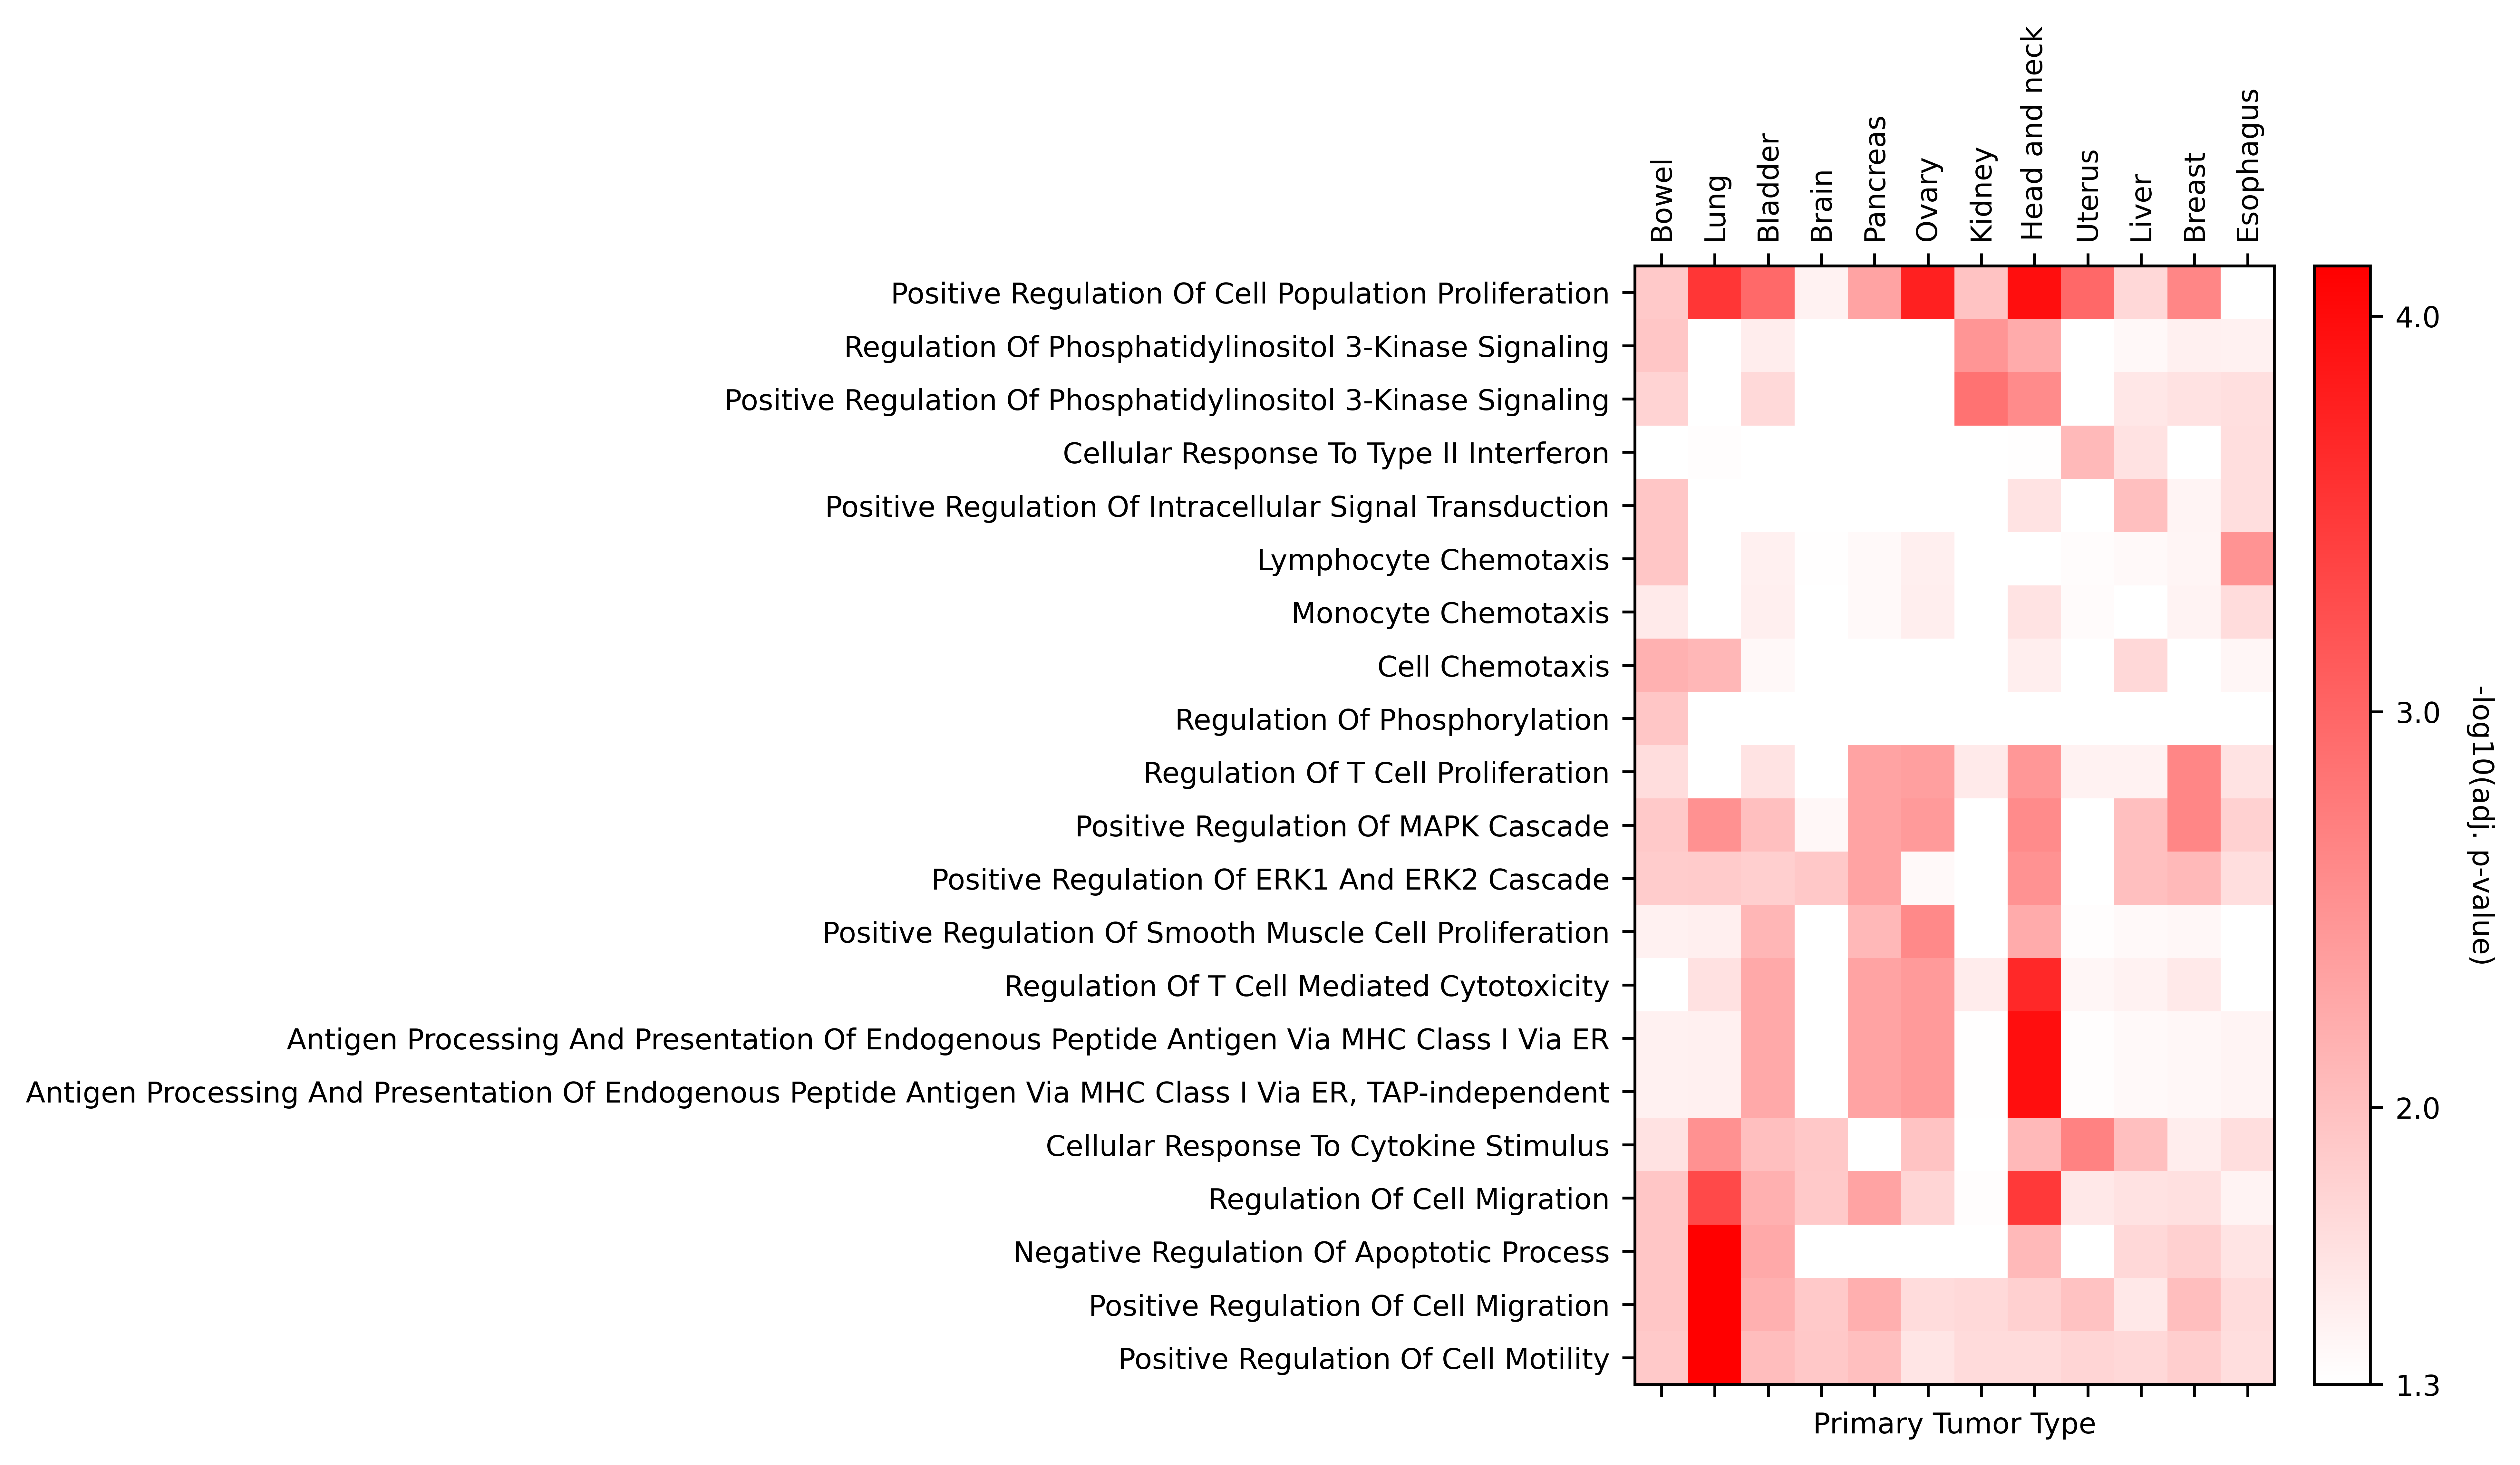

In [91]:
from matplotlib.colors import LinearSegmentedColormap, Normalize
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

# Assuming df is your pandas dataframe
# Convert the dataframe to numpy array for plotting
data = top_df.to_numpy()

# Perform hierarchical clustering on rows only
row_linkage = sch.linkage(pdist(data), method='average')  
dendrogram_row_order = sch.leaves_list(row_linkage)

# Reorder the rows based on the clustering result
ordered_data = data[dendrogram_row_order, :]

# Threshold for significance (-log10(0.05) for example)
threshold = -np.log10(0.05)

# Create a masked array: values below the threshold will be masked (set to white)
masked_data = np.ma.masked_less(ordered_data, threshold)

# Create a custom colormap that goes from white to red
cmap = LinearSegmentedColormap.from_list("custom_reds", ["white", "red"], N=256)

# Create a figure and axis
plt.figure(figsize=(5, 4))

# Normalize values between the threshold and max, where values below threshold are white
norm = Normalize(vmin=threshold, vmax=ordered_data.max())

# Plot the matrix using the custom colormap and normalization
cax = plt.matshow(masked_data, cmap=cmap, norm=norm)

# Add a colorbar
cbar = plt.colorbar(cax, shrink=0.8)  # Adjust shrink to make the colorbar smaller

# Add annotation/label to the colorbar
cbar.set_label('-log10(adj. p-value)', rotation=270, labelpad=15, fontsize=8)

# Set specific ticks, including the threshold
tick_values = [round(threshold, 2), 2, 3, 4]  # Add values as needed
cbar.set_ticks(tick_values)
cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in tick_values], fontsize=8)  # Format with one decimal

# Set axis labels
plt.xticks(np.arange(top_df.shape[1]), top_df.columns.str.capitalize(), rotation=90, fontsize=8)  # Keep original column order
plt.yticks(np.arange(top_df.shape[0]), top_df.index[dendrogram_row_order], fontsize=8)

# Add labels and title
plt.xlabel('Primary Tumor Type', fontsize=8)
# plt.ylabel('Significant Pathways')
plt.grid(False)
plt.tight_layout()

# Show the plot
# plt.show()


# Differential expression analysis-based feature ranking

In [116]:
# identify DEGs
all_deg_ad = dict()
for tumor_interest in all_tumors:
    all_deg_ad[tumor_interest] = dict()
    print(tissue_interest)
    for site in all_sites:
        print(site)
        
        tissue_ad = adata[adata.obs.new_tissue == tumor_interest]
        tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
        del tissue_ad.uns['log1p']
        try:
            if site == 'Neg':
                # positive fold change, high in group 0
                sc.tl.rank_genes_groups(tissue_ad, groupby=site+'.1va', reference = '1')
            else:
                sc.tl.rank_genes_groups(tissue_ad, groupby=site+'.1va', reference = '0') 
            all_deg_ad[tumor_interest][site] = sc.get.rank_genes_groups_df(tissue_ad, group=None)['names'].to_numpy()[:num_gene]
        except:
            continue

ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver


/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site

bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney


/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site

liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone


/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site

lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung


/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/home/wang3712/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/home/wang3712/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tiss

brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver


/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site

bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain
ESOPHAGUS/STOMACH
Neg
kidney
liver
bone
lung
brain


/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site+'.1va'] = tissue_ad.obs[site+'.1va'].astype(str)
/tmp/ipykernel_10871/1363529243.py:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  tissue_ad.obs[site

In [118]:
pathway_results_deg = dict()
for tumor in all_deg_ad.keys():
    time.sleep(1)
    print(tumor)
    pathway_results_deg[tumor] = dict()
    for site in all_deg_ad[tumor].keys():
        print(site)
        time.sleep(1)
        genes = all_deg_ad[tumor][site]
        new_genes = []
        for i in genes:
            try:
                new_genes.append(ensg_to_refseq[i])
            except:
                continue
        genes_str = '\n'.join(new_genes)
        print(new_genes[:5])
        description = tumor+'_'+site
        payload = {
            'list': (None, genes_str),
            'description': (None, description)
        }
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/addList'

        
        response = requests.post(ENRICHR_URL, files=payload)
        if not response.ok:
            raise Exception('Error analyzing gene list')
        
        data = json.loads(response.text)
        
        user_list_id = data['userListId']   
        # print(user_list_id)
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/view?userListId=%s'
        
        response = requests.get(ENRICHR_URL % user_list_id)
        if not response.ok:
            raise Exception('Error getting gene list')

        data = json.loads(response.text)
        # user_list_id = data['userListId']   

        
        ENRICHR_URL = 'https://maayanlab.cloud/Enrichr/enrich'
        query_string = '?userListId=%s&backgroundType=%s'
        gene_set_library = 'GO_Biological_Process_2023'
        response = requests.get(
            ENRICHR_URL + query_string % (user_list_id, gene_set_library)
         )
        
        if not response.ok:
            raise Exception('Error fetching enrichment results')

        data = json.loads(response.text)
        for d in data[gene_set_library][:3]:
            print(d[1])

        pathway_results_deg[tumor][site] = data[gene_set_library]
        

BOWEL
Neg
['UGCG', 'A4GALT', 'FBXO2', 'ST3GAL1', 'APBB1']
Positive Regulation Of ERK1 And ERK2 Cascade (GO:0070374)
Positive Regulation Of MAPK Cascade (GO:0043410)
Regulation Of ERK1 And ERK2 Cascade (GO:0070372)
liver
['PRKAG2', 'CAPN2', 'GABBR1', 'FZD6', 'NLGN2']
Positive Regulation Of Protein Phosphorylation (GO:0001934)
Positive Regulation Of Apoptotic Process (GO:0043065)
Response To Cytokine (GO:0034097)
bone
['CD44', 'DHRS3', 'INPP4B', 'MET', 'GAD1']
Mesodermal Cell Differentiation (GO:0048333)
Regulation Of Cell Population Proliferation (GO:0042127)
Regulation Of Cell Migration (GO:0030334)
lung
['RAMP1', 'CD47', 'ICAM2', 'GSTM3', 'STX2']
Regulation Of Apoptotic Process (GO:0042981)
Negative Regulation Of Apoptotic Process (GO:0043066)
Regulation Of Wound Healing (GO:0061041)
brain
['GALNT18', 'PARVA', 'DTX3', 'EBP', 'PARVB']
Positive Regulation Of Intracellular Signal Transduction (GO:1902533)
Transmembrane Receptor Protein Tyrosine Kinase Signaling Pathway (GO:0007169)
Regul

In [127]:
site = 'Neg'
num_pathway = 3
all_top_pathways_deg = set()
for tumor in pathway_results_deg.keys():
    # print(tumor)
    try:
        # print(len(pathway_results_deg[tumor][site]))
        res = pathway_results_deg[tumor][site][:num_pathway]
        # print(res)
        for r in res:
            all_top_pathways_deg.add(r[1])
    except:
        continue
print('Found', len(all_top_pathways_deg), 'top pathways')    

top_pathway_dict_deg = dict()

for tumor in pathway_results_deg.keys():
    print(tumor)
    
    try:
        res = pathway_results_deg[tumor][site]
        top_pathway_dict_deg[tumor] = dict()
        # print(res)
        for r in res:
            if r[1] in all_top_pathways_deg:
                top_pathway_dict_deg[tumor][r[1]] = r[-3]
    except:
        continue
# all_top_pathways    

Found 32 top pathways
BOWEL
SKIN
LUNG
BLADDER
BRAIN
PANCREAS
OVARY
KIDNEY
HEAD AND NECK
UTERUS
LIVER
BREAST
ESOPHAGUS


In [128]:
top_df = pd.DataFrame.from_dict(top_pathway_dict_deg)
top_df = top_df.dropna()
top_df.index = [i.split(' (')[0] for i in top_df.index]
top_df = -np.log10(top_df)
top_df

,BOWEL,LUNG,BLADDER,BRAIN,PANCREAS,OVARY,KIDNEY,HEAD AND NECK,UTERUS,LIVER,BREAST,ESOPHAGUS
Positive Regulation Of ERK1 And ERK2 Cascade,6.877950,1.485486,1.038876,2.858035,0.528014,0.536865,0.813885,2.659436,0.212012,0.528566,0.972358,2.194119
Positive Regulation Of MAPK Cascade,6.501017,1.669937,0.895415,2.059809,0.554951,0.558189,0.887658,3.280766,0.539169,0.552770,0.750563,3.413835
Regulation Of ERK1 And ERK2 Cascade,5.811717,1.102882,0.852632,2.858035,0.404240,0.826431,0.705172,2.659436,0.143820,0.409794,0.817870,2.245856
Transmembrane Receptor Protein Tyrosine Kinase Signaling Pathway,2.476360,0.801937,1.698693,2.158578,0.112941,0.597080,0.840406,0.659883,0.802040,0.786678,2.561002,3.074818
Positive Regulation Of Cell Migration,1.614138,0.823184,1.752298,0.632804,0.617326,2.372252,0.851744,2.511756,0.592009,0.990137,2.295013,4.509691
Regulation Of Cell Migration,1.356704,1.842581,3.538666,1.116384,0.588589,1.672953,1.395539,4.342976,0.685064,0.849698,2.295013,4.652136
Positive Regulation Of Cytokine Production,0.987620,0.562699,0.878204,0.300823,0.738902,0.750450,0.304323,3.575426,0.678034,1.519114,0.746598,1.462024


/tmp/ipykernel_10871/3831669531.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 2000x1600 with 0 Axes>

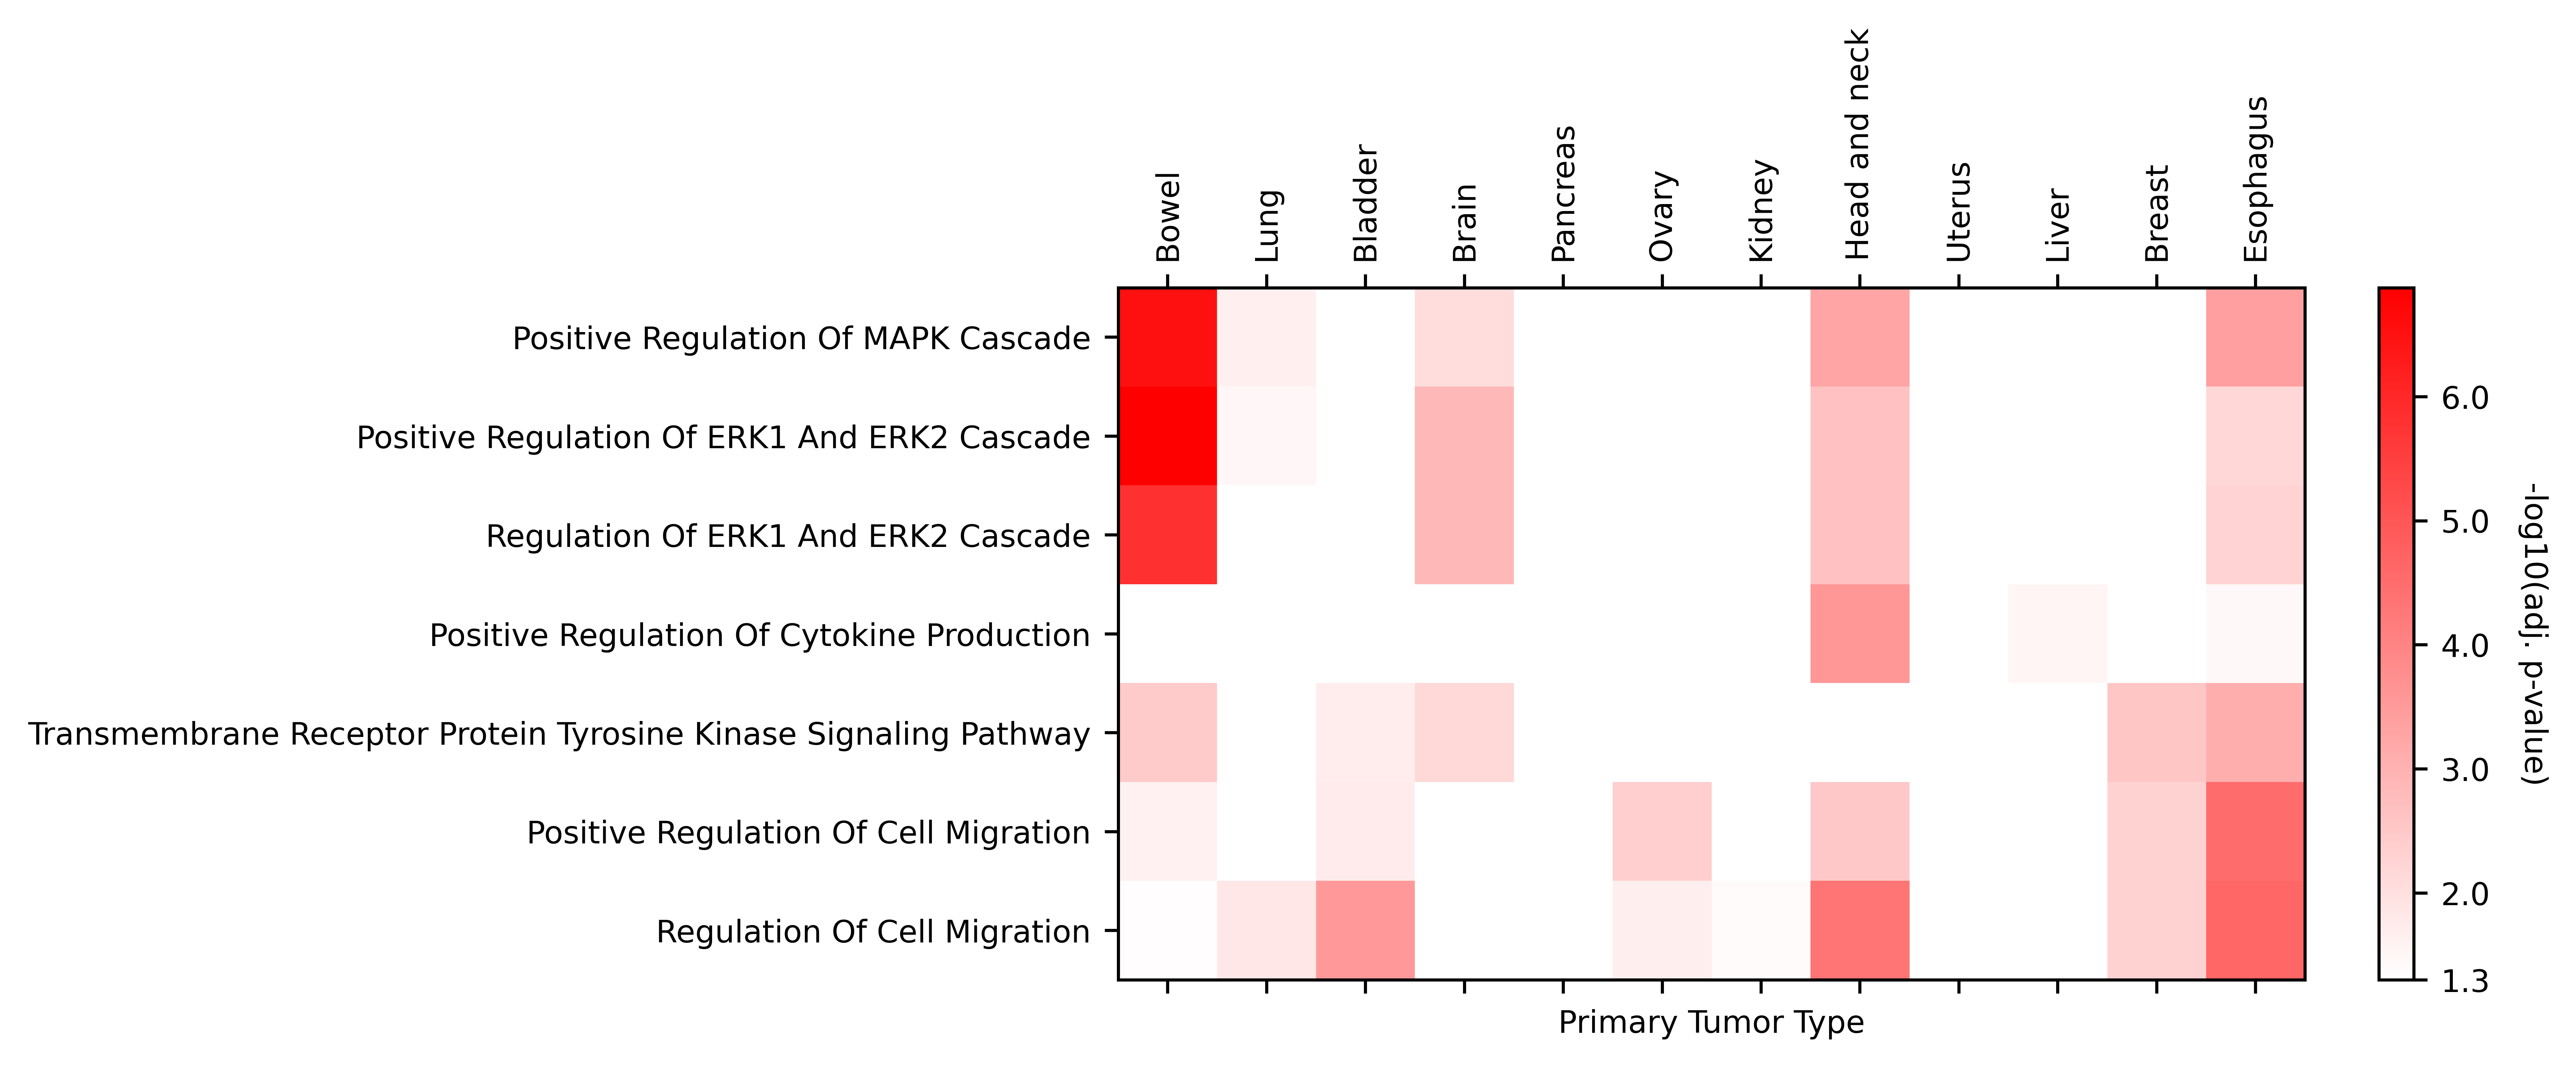

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, Normalize
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

# Assuming df is your pandas dataframe
# Convert the dataframe to numpy array for plotting
data = top_df.to_numpy()

# Perform hierarchical clustering on rows only
row_linkage = sch.linkage(pdist(data), method='average')  # Hierarchical clustering for rows
dendrogram_row_order = sch.leaves_list(row_linkage)

# Reorder the rows based on the clustering result
ordered_data = data[dendrogram_row_order, :]

# Threshold for significance (-log10(0.05) for example)
threshold = -np.log10(0.05)

# Create a masked array: values below the threshold will be masked (set to white)
masked_data = np.ma.masked_less(ordered_data, threshold)

# Create a custom colormap that goes from white to red
cmap = LinearSegmentedColormap.from_list("custom_reds", ["white", "red"], N=256)

# Create a figure and axis
plt.figure(figsize=(5, 4))

# Normalize values between the threshold and max, where values below threshold are white
norm = Normalize(vmin=threshold, vmax=ordered_data.max())

# Plot the matrix using the custom colormap and normalization
cax = plt.matshow(masked_data, cmap=cmap, norm=norm)

# Add a colorbar
cbar = plt.colorbar(cax, shrink=0.8)  # Adjust shrink to make the colorbar smaller

# Add annotation/label to the colorbar
cbar.set_label('-log10(adj. p-value)', rotation=270, labelpad=15, fontsize=8)

# Set specific ticks, including the threshold
tick_values = [round(threshold, 2), 2, 3, 4, 5, 6]  # Add values as needed
cbar.set_ticks(tick_values)
cbar.ax.set_yticklabels([f'{tick:.1f}' for tick in tick_values], fontsize=8)  # Format with one decimal

# Set axis labels
plt.xticks(np.arange(top_df.shape[1]), top_df.columns.str.capitalize(), rotation=90, fontsize=8)  # Keep original column order
plt.yticks(np.arange(top_df.shape[0]), top_df.index[dendrogram_row_order], fontsize=8)

# Add labels and title
plt.xlabel('Primary Tumor Type', fontsize=8)
# plt.ylabel('Significant Pathways')
plt.grid(False)
plt.tight_layout()

# Show the plot
# plt.show()
# plt.savefig('Pathways.Neg.DEG.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0.1)
